In [1]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import datetime
import math
import matplotlib.dates as mdates # for timestamps
import seaborn as sns

pd.options.display.max_rows = 14

In [2]:
df = pd.read_csv("../data/data_Zhadang_localtime.csv", index_col=0,
                 parse_dates=True)


# Set default formatting for all plots
def plot_format():
    plt.rc("axes", labelsize=22, titlesize=24, labelpad=10)
    plt.rc("legend", fontsize=22)
    plt.rc("xtick", labelsize=18)
    plt.rc("ytick", labelsize=18)

# sns.set()
plot_format()

In [3]:
# Define constants
k = 0.4
z_0m = 0.0017  # m
z_m = 2  # m
z_h = 2  # m
z_0h = 0.0012  # m
z_v = 2  # m
z_0v = 0.0012  # m
c_p = 1005  # J kg^-1 K^-1
rho = 1.29  # kg m^-3
P_0 = 1013.25  # hPa
T_0 = 273.15  # K
R_v = 465  # J kg^-1 K^-1
L_v = 2500000  # J kg^-1
L_s = 2830000  # J kg^-1

# 2. Turbulent fluxes
## 2.1 Sensible Heat Flux

Use the standard values from the appendix and the observations of Ts, Ta, and p at Zhadang to compute the sensible heat flux  QH. Plot it. When is it the most variable and why?

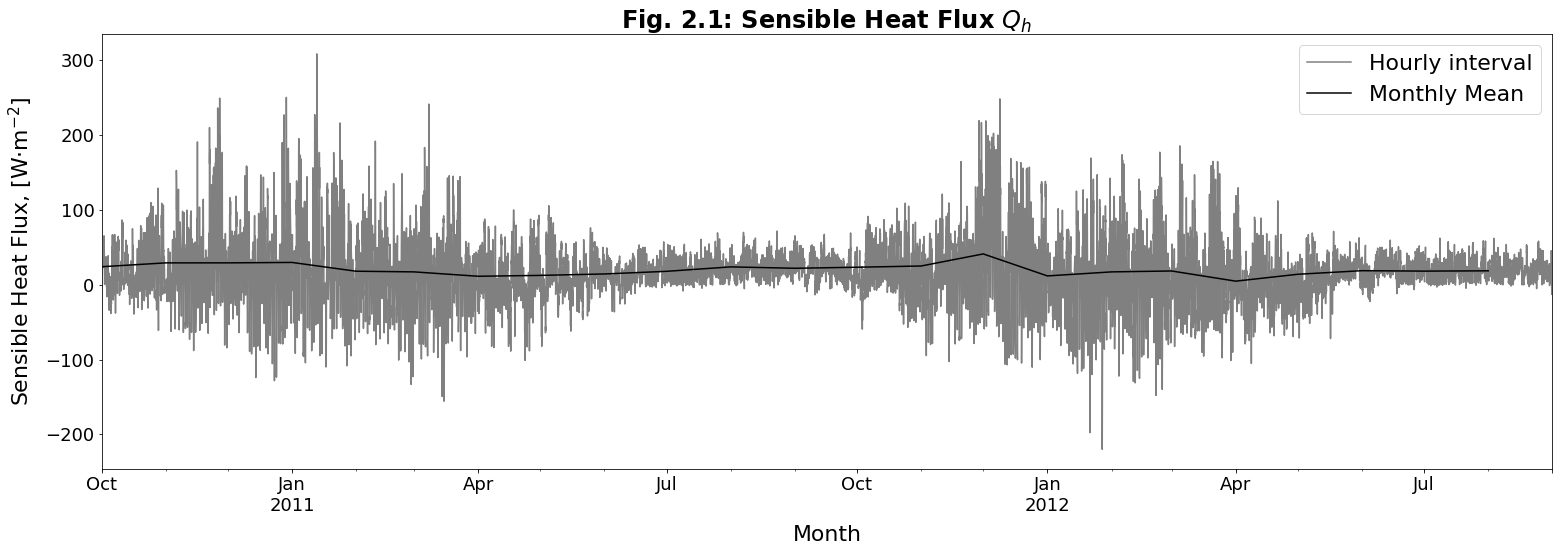

In [38]:
# Sensible heat flux
Q_H = (c_p * rho * df["PRESSURE"] * (k ** 2) * df["WINDSPEED"] * (
        df["TEMP"] - df["SURFTEMP"])) / (
              P_0 * math.log(z_m / z_0m) * math.log(z_h / z_0h))
df["Q_H"] = Q_H

# Resample into monthly mean
monthly_mean = df.resample("MS").mean()

plt.figure(figsize=(26, 8))
Q_H.plot(color="grey", label="Hourly interval")
monthly_mean["Q_H"].plot(label="Monthly Mean", color="black")
plt.legend(loc="upper right")
plt.title(r"Fig. 2.1: Sensible Heat Flux $Q_{h}$",
          fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
plt.show()

Plot the daily cycle of Q H in the months of January and July. When is QH negative/positive, and why?

In [5]:
# Split datetime for easier graphing
df["month"] = df.index.to_series().dt.strftime("%b")
df["day"] = df.index.to_series().dt.strftime("%d")

df["noyear"] = df.index.to_series().dt.strftime("%m-%d %H:00")
df["nomonth"] = df.index.to_series().dt.strftime("%d %H:00")

In [6]:
# Working with datetime objects was too much of a hassle when
# graphing, so switched to multiindexing

# Averages each hour across all years
df_hour_mean = df.groupby([df.index.month, df.index.day, df.index.hour]).mean()
df_hour_mean.index = df_hour_mean.index.set_names(["month", "day", "hour"])
df_hour_mean.sort_index(inplace=True)

jan_hour_mean = df_hour_mean.loc[1, :, :]
jul_hour_mean = df_hour_mean.loc[7, :, :]

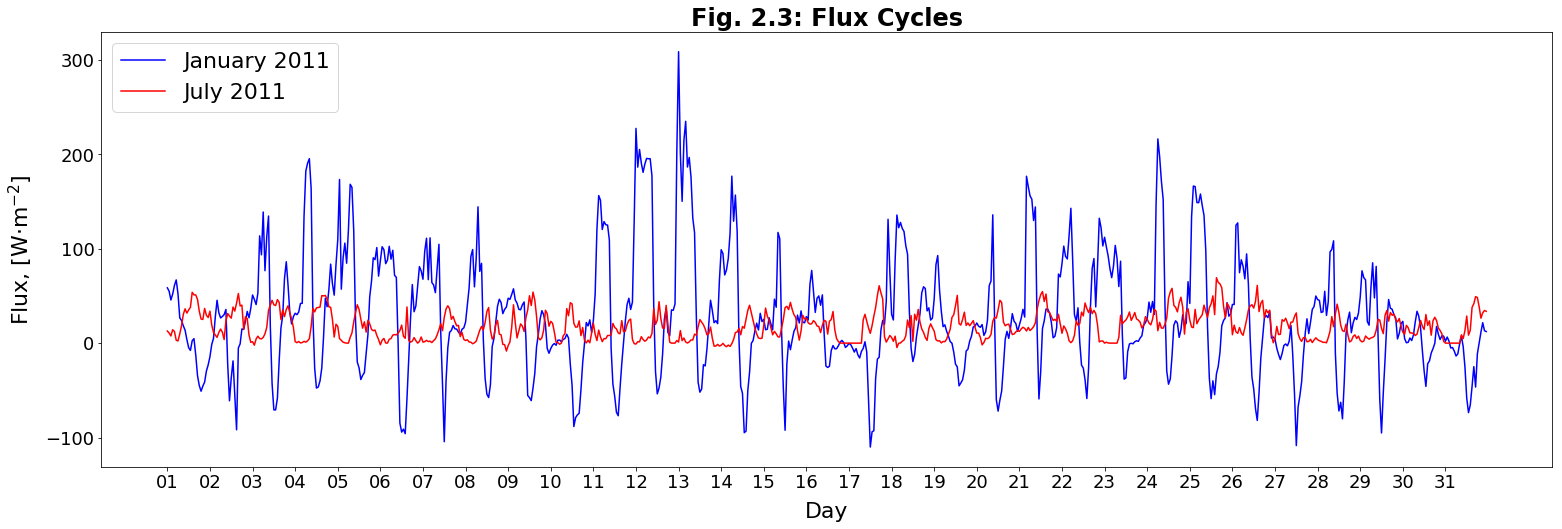

In [41]:
# Create plots and merge
plt.figure(figsize=(26, 8))
plt.plot(df.loc["2011-01"]["nomonth"], df.loc["2011-01"]["Q_H"],
         label="January 2011", color="b")
plt.plot(df.loc["2011-07"]["nomonth"], df.loc["2011-07"]["Q_H"],
         label="July 2011", color="r")

plt.xticks(np.arange(0, 744, step=24), df.loc["2011-07"]["day"][::24])
plt.legend(loc="upper left")

plt.title(r"Fig. 2.3: Flux Cycles",
          fontweight="bold")
plt.xlabel("Day")
plt.ylabel("Flux, [W$\cdot$m$^{-2}$]")
plt.show()

## 2.2 Latent Heat Flux

Use the formulas given in the appendix to compute the water vapor pressure of air and the saturation vapor pressure at the surface from the observations at Zhadang.

In [8]:
# Define L for surface temperatures
df["L"] = np.where(df["SURFTEMP"] + T_0 >= T_0, L_v, L_s)

# Saturation vapour pressure at the surface
# Convert temperature to Kelvins to avoid dividing by zero
df["e_s"] = 6.11 * np.exp(
    ((df["L"][0] / R_v) * ((1 / T_0) - (1 / (df["SURFTEMP"] + T_0)))))
# Water vapour pressure of air
df["e_a"] = df["RH"] / 100 * df["e_s"]

Compute the latent heat flux QL using the standard values from the appendix. Plot it. When is it the most variable and why?

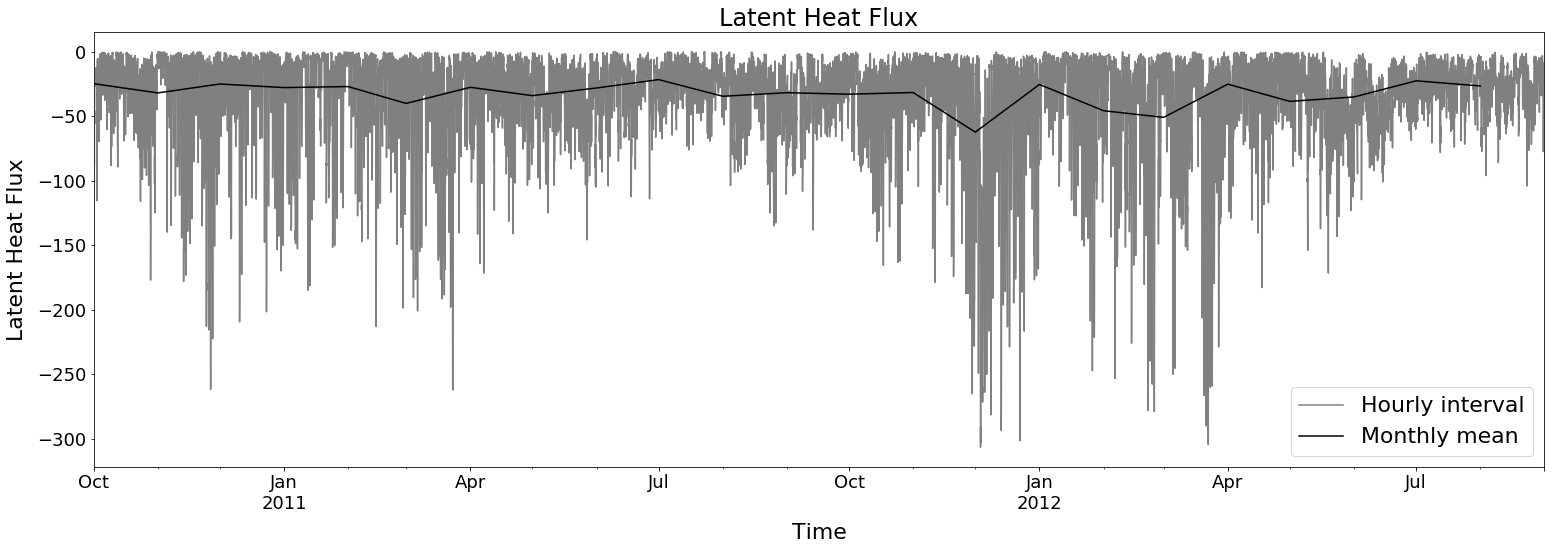

In [39]:
# Compute latent heat flux
df["Q_L"] = 0.623 * df["L"] * rho * (k ** 2 * df["WINDSPEED"]
                                     * (df["e_a"] - df["e_s"])) / (
        P_0 * math.log(z_m / z_0m) * math.log(z_v / z_0v))

# Resample into monthly mean
monthly_mean["Q_L"] = df["Q_L"].resample("MS").mean()  # note this also changes ["L"]

plt.figure(figsize=(26, 8))
ax = df["Q_L"].plot(label="Hourly interval", color="grey")
monthly_mean["Q_L"].plot(label="Monthly mean", color="black")
plt.legend(loc="lower right")

ax.set_title('Latent Heat Flux')
plt.xlabel("Time")
plt.ylabel("Latent Heat Flux")
plt.show()

Plot the daily cycle of QL for the months of January and July. When is QL negative/positive, and why

# 2.3 Flux Comparison
Plot the monthly averages of QH and QL for the entire measurement period.

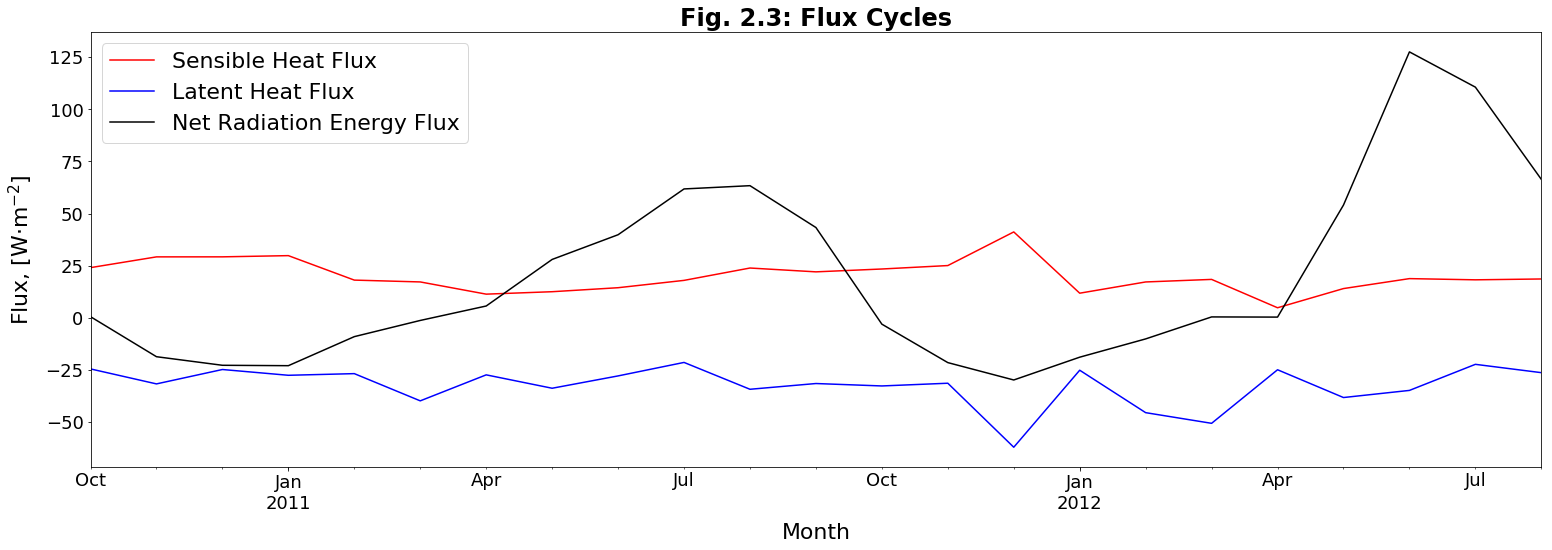

In [40]:
# Resample into monthly means
monthly_mean = df.resample("MS").mean()  # note this also changes ["L"]

plt.figure(figsize=(26, 8))
monthly_mean["Q_H"].plot(label="Sensible Heat Flux", color="red")
monthly_mean["Q_L"].plot(label="Latent Heat Flux", color="blue")
monthly_mean["NETRAD"].plot(label="Net Radiation Energy Flux", color="black")
plt.legend(loc="upper left")

plt.title(r"Fig. 2.3: Flux Cycles",
          fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Flux, [W$\cdot$m$^{-2}$]")
plt.show()

**Q:** Compare them with the net radiation energy flux. When will the turbulent fluxes play an important role, and when are they less relevant to the surface
energy balance?

**A:** 

# 2.4 Sensitivity to the meteorological conditions.

Compute the turbulent fluxes with changed meteorological conditions: ± 1K for air temperature, ±10% for wind speed. Display the results of the sensitivity experiments on the same plot.

*Does "same plot" mean [Qh], [QL] or [Qh, QL]?*

In [11]:
# Calculate new sensible heat fluxes
df["Q_H+"] = (c_p * rho * df["PRESSURE"] * (k ** 2) * (df["WINDSPEED"] * 1.1)
              * ((df["TEMP"] + 1) - df["SURFTEMP"])) / (
                     P_0 * math.log(z_m / z_0m) * math.log(z_h / z_0h))
df["Q_H-"] = (c_p * rho * df["PRESSURE"] * (k ** 2) * (df["WINDSPEED"] * 0.9)
              * ((df["TEMP"] - 1) - df["SURFTEMP"])) / (
                     P_0 * math.log(z_m / z_0m) * math.log(z_h / z_0h))

# Calculate new latent heat flux
# L does not need to be redefined since independent of air temperature
df["Q_L+"] = 0.623 * df["L"] * rho * (k ** 2 * (df["WINDSPEED"] * 1.1)
                                      * (df["e_a"] - df["e_s"])) / (
                     P_0 * math.log(z_m / z_0m) * math.log(z_v / z_0v))

df["Q_L-"] = 0.623 * df["L"] * rho * (k ** 2 * (df["WINDSPEED"] * 0.9)
                                      * (df["e_a"] - df["e_s"])) / (
                     P_0 * math.log(z_m / z_0m) * math.log(z_v / z_0v))

monthly_mean = df.resample("MS").mean()  # note this also changes ["L"]

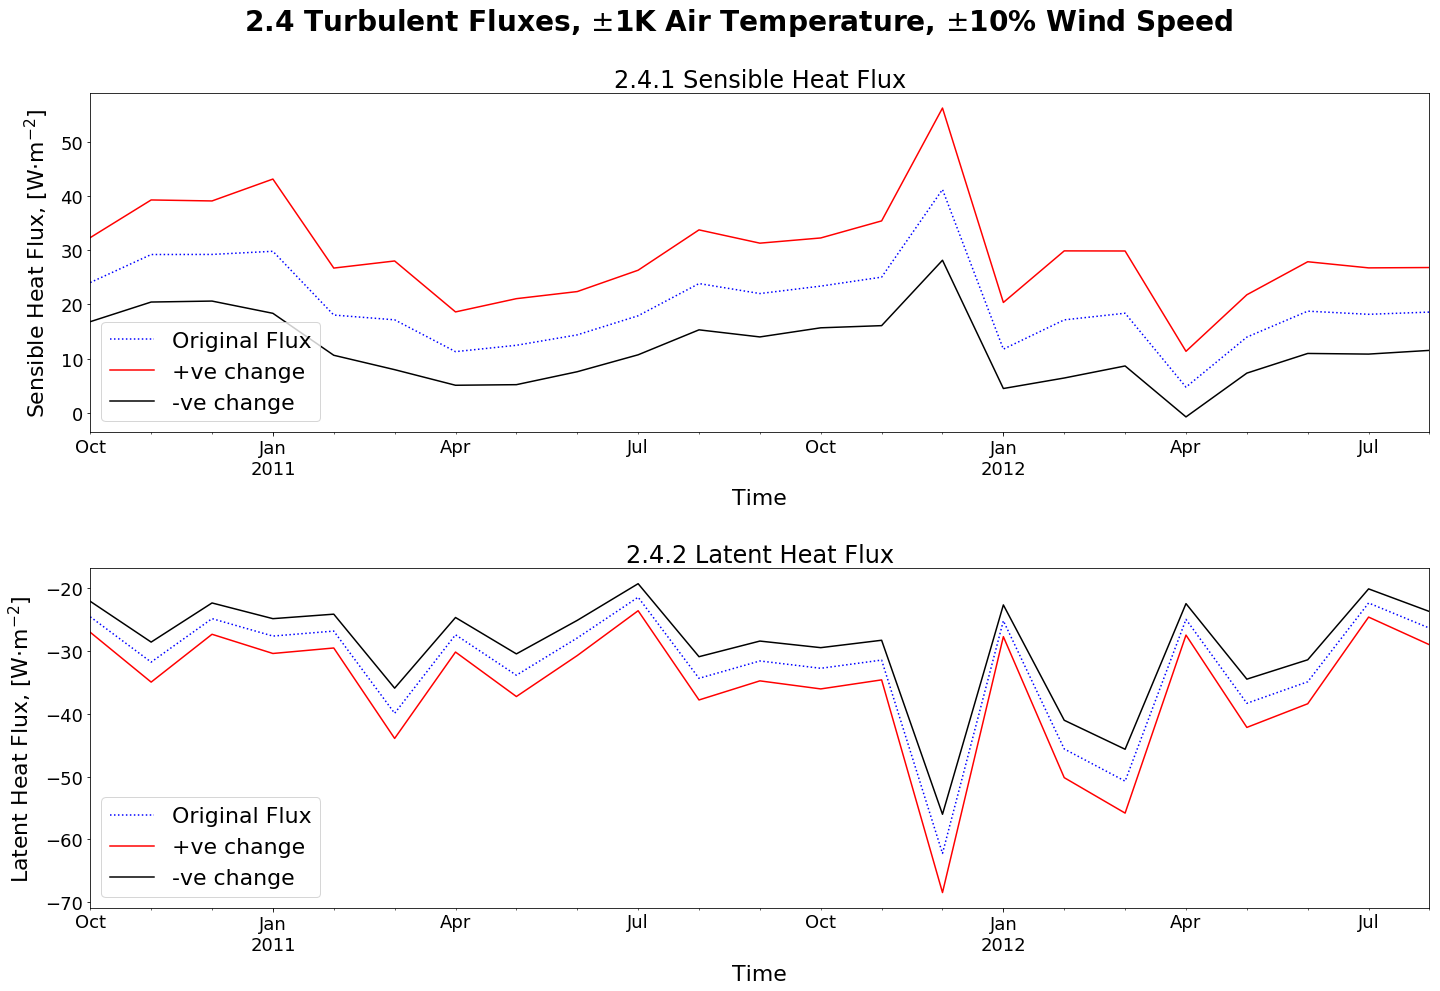

In [12]:
# Question ambiguous - assumed "results... on the same plot" meant each
# experiment on its own plot

fig, axarray = plt.subplots(2, 1, figsize=(24, 15))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("2.4 Turbulent Fluxes, $\pm$1K Air Temperature, $\pm$10% Wind "
             "Speed", fontsize=28, fontweight="bold", y=0.96)

axarray[0] = plt.subplot(2, 1, 1)
monthly_mean["Q_H"].plot(ax=axarray[0], label="Original Flux", color="b",
                        linestyle="dotted")
monthly_mean["Q_H+"].plot(ax=axarray[0], label="+ve change", color="r")
monthly_mean["Q_H-"].plot(ax=axarray[0], label="-ve change", color="black")

axarray[0].set_title("2.4.1 Sensible Heat Flux")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
plt.legend(loc="lower left")

axarray[1] = plt.subplot(2, 1, 2)
monthly_mean["Q_L"].plot(ax=axarray[1], label="Original Flux", color="b",
                        linestyle="dotted")
monthly_mean["Q_L+"].plot(ax=axarray[1], label="+ve change", color="r")
monthly_mean["Q_L-"].plot(ax=axarray[1], label="-ve change", color="black")

axarray[1].set_title("2.4.2 Latent Heat Flux")
plt.xlabel("Time")
plt.ylabel("Latent Heat Flux, [W$\cdot$m$^{-2}$]")
plt.legend(loc="lower left")
plt.show()

Analyse the results. Why is QL also dependent on air temperature changes? Do such sensitivity experiments actually make sense, physically?

# 2.5 Sensitivity to the measurement heights.

Assess the importance of this varying snow cover conditions on sensor height by changing the measurement heights by ± 1 m. Discuss the importance of these parameters.

In [13]:
# Calculate new sensible heat fluxes
df["Q_H+1m"] = (c_p * rho * df["PRESSURE"] * (k ** 2) * df["WINDSPEED"]
                * (df["TEMP"] + 1 - df["SURFTEMP"])) / (
        P_0 * math.log((z_m + 1) / z_0m) * math.log((z_h + 1) / z_0h))
df["Q_H-1m"] = (c_p * rho * df["PRESSURE"] * (k ** 2) * df["WINDSPEED"]
                * (df["TEMP"] + 1 - df["SURFTEMP"])) / (
        P_0 * math.log((z_m - 1) / z_0m) * math.log((z_h - 1) / z_0h))

# Calculate new latent heat fluxes
df["Q_L+1m"] = 0.623 * df["L"] * rho * (k ** 2 * df["WINDSPEED"]
                                        * (df["e_a"] - df["e_s"])) / (
        P_0 * math.log((z_m + 1) / z_0m) * math.log((z_v + 1) / z_0v))
df["Q_L-1m"] = 0.623 * df["L"] * rho * (k ** 2 * df["WINDSPEED"]
                                        * (df["e_a"] - df["e_s"])) / (
        P_0 * math.log((z_m - 1) / z_0m) * math.log((z_v - 1) / z_0v))

monthly_mean = df.resample("MS").mean()  # note this also changes ["L"]

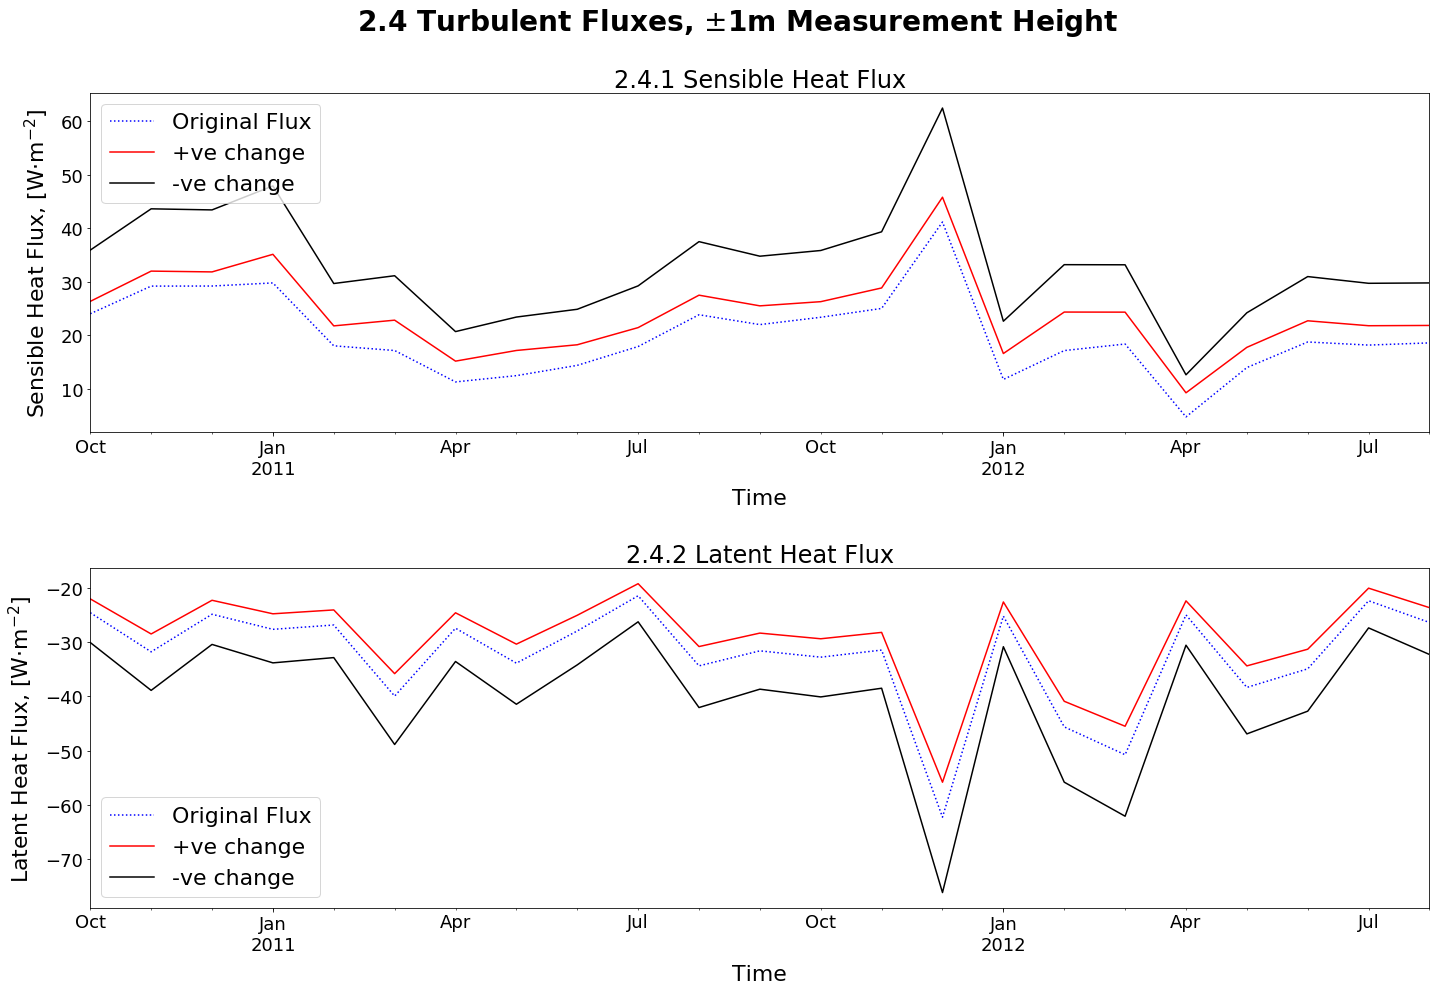

In [14]:
# Question ambiguous - assumed "results... on the same plot" meant each
# experiment on its own plot

fig, axarray = plt.subplots(2, 1, figsize=(24, 15))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("2.4 Turbulent Fluxes, $\pm$1m Measurement Height", fontsize=28,
             fontweight="bold", y=0.96)

axarray[0] = plt.subplot(2, 1, 1)
monthly_mean["Q_H"].plot(ax=axarray[0], label="Original Flux", color="b",
                        linestyle="dotted")
monthly_mean["Q_H+1m"].plot(ax=axarray[0], label="+ve change", color="r")
monthly_mean["Q_H-1m"].plot(ax=axarray[0], label="-ve change", color ="black")

axarray[0].set_title("2.4.1 Sensible Heat Flux")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
plt.legend(loc="upper left")

axarray[1] = plt.subplot(2, 1, 2)
monthly_mean["Q_L"].plot(ax=axarray[1], label="Original Flux", color="b",
                        linestyle="dotted")
monthly_mean["Q_L+1m"].plot(ax=axarray[1], label="+ve change", color="r")
monthly_mean["Q_L-1m"].plot(ax=axarray[1], label="-ve change", color="black")

axarray[1].set_title("2.4.2 Latent Heat Flux")
plt.xlabel("Time")
plt.ylabel("Latent Heat Flux, [W$\cdot$m$^{-2}$]")
plt.legend(loc="lower left")
plt.show()

# 2.6 Sensitivity to the roughness parameters.
List some factors that can affect the roughness lengths. Find information on the order of magnitude by which these
roughness lengths can vary over a glacier surface.

**A:** According to Oke (1987) and Stull (1988), The total roughness lengths may vary due to:
* Surface type, such as fresh snow, ice, dirty ice, melt ponds, etc.
* The size and shape of roughness elements, such as boulders, penitentes, and other protusions.
* The density distribution of the roughness elements. 

The change in magnitude of glacier roughness lengths depends on the type of surface and state of melt.

Propose a sensitivity experiment for changing the roughness parameters altogether and plot the results.

In [ ]:
# Calculate new sensible heat fluxes
df["Q_H+rl"] = (c_p * rho * df["PRESSURE"] * (k ** 2) * df["WINDSPEED"]
                * (df["TEMP"] + 1 - df["SURFTEMP"])) / (
        P_0 * math.log((z_m + 1) / z_0m) * math.log((z_h + 1) / z_0h))
df["Q_H-rl"] = (c_p * rho * df["PRESSURE"] * (k ** 2) * df["WINDSPEED"]
                * (df["TEMP"] + 1 - df["SURFTEMP"])) / (
        P_0 * math.log((z_m - 1) / z_0m) * math.log((z_h - 1) / z_0h))

# Calculate new latent heat fluxes
df["Q_L+rl"] = 0.623 * df["L"] * rho * (k ** 2 * df["WINDSPEED"]
                                        * (df["e_a"] - df["e_s"])) / (
        P_0 * math.log((z_m + 1) / z_0m) * math.log((z_v + 1) / z_0v))
df["Q_L-rl"] = 0.623 * df["L"] * rho * (k ** 2 * df["WINDSPEED"]
                                        * (df["e_a"] - df["e_s"])) / (
        P_0 * math.log((z_m - 1) / z_0m) * math.log((z_v - 1) / z_0v))

monthly_mean = df.resample("MS").mean()  # note this also changes ["L"]

Discuss the importance of these parameters, and the uncertainty associated with setting them as constant.